In [1]:
import adi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.fft as fft
import scipy.signal as signal
from pandas import read_csv, DataFrame
import matplotlib as mpl
import functools
from timeit import default_timer as timer
%matplotlib inline

In [2]:
# Конструктор для сигнала, состоящего из косинусов
def cosines(amplitudes, frequencies):
    return lambda t:  functools.reduce(lambda acc, harmonic: acc + harmonic[0]*np.cos(2 * np.pi * harmonic[1] * t), zip(amplitudes, frequencies), 0)

# Конструктор для сигнала, состоящего из синусов
def sines(amplitudes, frequencies):
    return lambda t:  functools.reduce(lambda acc, harmonic: acc + harmonic[0]*np.sin(2 * np.pi * harmonic[1] * t), zip(amplitudes, frequencies), 0)

def get_averaged_spectrum(sdr, average=10):
    signal = sdr.rx()
    for i in range(average-1):
        signal = signal + sdr.rx()
    signal = signal / average
    spectrum = fft.fftshift(fft.fft(signal))
    frequencies = fft.fftshift(fft.fftfreq(signal.shape[0], 1 / sdr.sample_rate) + sdr.rx_lo) / 1e6
    return DataFrame(data = spectrum.imag**2 + spectrum.real**2, index = frequencies)

def dbg(x):
    print(x)
    return x

In [3]:
lattice_center = 5 # in length domain, micrometers
lattice_center_freq = 5 # Hz
lattice_step = 5 # micrometers
alpha = 1

laser_amplitude = 1
laser_switching_time = 1
laser_switching_speed = laser_amplitude / laser_switching_time
atom_speed = 1 # in frequency domain, Hz/s 
def generate_signal(input_array):
    # all the lengths are in micrometers
    lattice_start = lattice_center - int(len(input_array) / 2) * lattice_step
#     print("lattice start", lattice_start)
    signals = []
    for num, atom in np.ndenumerate(input_array):
        start_freq = coord_to_freq(atom)
        end_freq = coord_to_freq(lattice_start + lattice_step * num[0])
        print("start & end freqs", start_freq, end_freq)
        print("transition time", tansition_time(start_freq, end_freq)*1e6, "us")
        signals.append(atom_signal(start_freq, end_freq))
    return np.vectorize(lambda t: functools.reduce(lambda acc, harmonic: acc + harmonic(t), signals,0))

def coord_to_freq(coord):
    # см. #вычисление угла на стр. 1
    return lattice_center_freq + alpha * (coord - lattice_center)

def atom_signal(start_freq, end_freq):
    def harmonic(t):
        freq_sign = 1 if end_freq > start_freq else -1
    #     print(laser_switching_time + freq_sign * (end_freq - start_freq)  / atom_speed)
        if t < laser_switching_time:
    #         print("turn on")
            return laser_switching_speed * t * np.cos(2*np.pi * start_freq * t)
        elif t < laser_switching_time + freq_sign * (end_freq - start_freq)  / atom_speed:
            local_t = t - laser_switching_time
    #         print("move", start_freq + freq_sign * atom_speed * local_t)
            return laser_amplitude * np.cos(2*np.pi *(start_freq + freq_sign * atom_speed * local_t) * t)
        elif t < laser_switching_time * 2 + freq_sign * (end_freq - start_freq)  / atom_speed:
            local_t = t - laser_switching_time - freq_sign * (end_freq - start_freq)  / atom_speed
    #         print("turn off", local_t)
            return (laser_amplitude - laser_switching_speed * local_t) * np.cos(2*np.pi * end_freq * t)
        else:
    #         print("off")
            return 0
    return harmonic

def tansition_time(start_freq, end_freq):
    return laser_switching_time * 2 + abs(end_freq - start_freq)  / atom_speed

In [4]:
golden_ratio = (np.sqrt(5) - 1) / 2
width = 6.7
height = width * golden_ratio

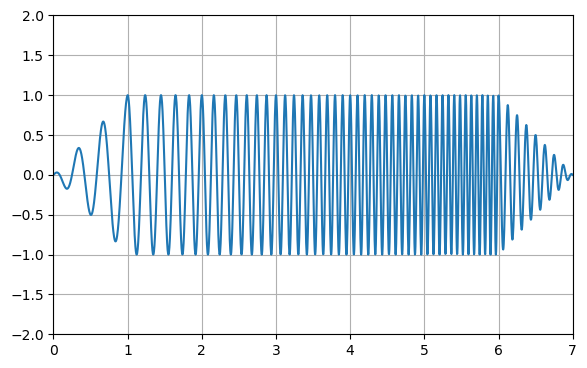

In [5]:
start = 0
end = 7
N = 2048
t = np.linspace(start, end, N)
input_array = np.array([13])
signal_function = np.vectorize(atom_signal(3,8))
# func = cosines(amplitudes, frequencies)
signal = signal_function(t)


plt.figure(figsize=(width, height))
plt.plot(t, signal)
plt.xlim(0,7)
plt.ylim(-2,2)
# plt.xlabel("время")
# plt.ylabel("сигнал")
# plt.axis('off')

plt.grid()
plt.savefig('/home/eugene/Documents/tab.digital/Studies/bachelor\'s/Pres/figures/signal1.pdf', bbox_inches='tight')
plt.show()

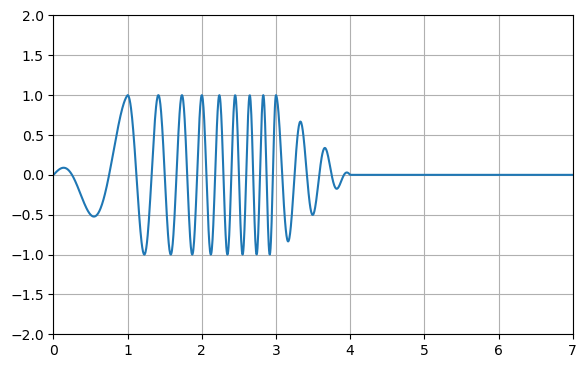

In [6]:
start = 0
end = 10
N = 2048
t = np.linspace(start, end, N)
input_array = np.array([13])
signal_function = np.vectorize(atom_signal(1,3))
# func = cosines(amplitudes, frequencies)
signal = signal_function(t)


golden_ratio = (np.sqrt(5) - 1) / 2
width = 6.7
height = width * golden_ratio
plt.figure(figsize=(width, height))
plt.plot(t, signal)
plt.xlim(0,7)
plt.ylim(-2,2)
# plt.xlabel("время")
# plt.ylabel("сигнал")
# plt.axis('off')
plt.grid()
plt.savefig('/home/eugene/Documents/tab.digital/Studies/bachelor\'s/Pres/figures/signal2.pdf', bbox_inches='tight')
plt.show()

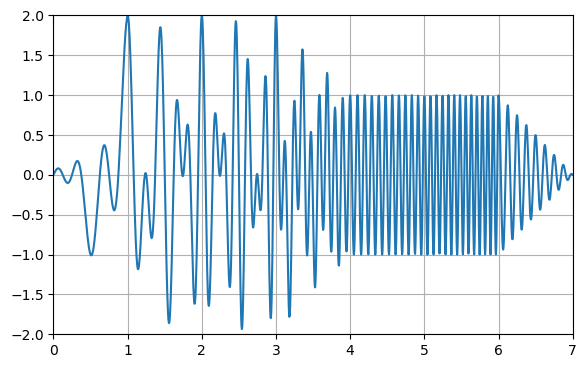

In [7]:
start = 0
end = 10
N = 2048
t = np.linspace(start, end, N)
input_array = np.array([13])
signal_function = np.vectorize(lambda t: atom_signal(1,3)(t) + atom_signal(3,8)(t))
# func = cosines(amplitudes, frequencies)
signal = signal_function(t)


golden_ratio = (np.sqrt(5) - 1) / 2
width = 6.7
height = width * golden_ratio
plt.figure(figsize=(width, height))
plt.plot(t, signal)
plt.xlim(0,7)
plt.ylim(-2,2)
# plt.xlabel("время")
# plt.ylabel("сигнал")
# plt.axis('off')
plt.grid()
plt.savefig('/home/eugene/Documents/tab.digital/Studies/bachelor\'s/Pres/figures/signal3.pdf', bbox_inches='tight')
plt.show()

In [8]:
spectrum = (fft.rfft(signal))
frequencies = (fft.rfftfreq(signal.shape[0], (end - start) / N))

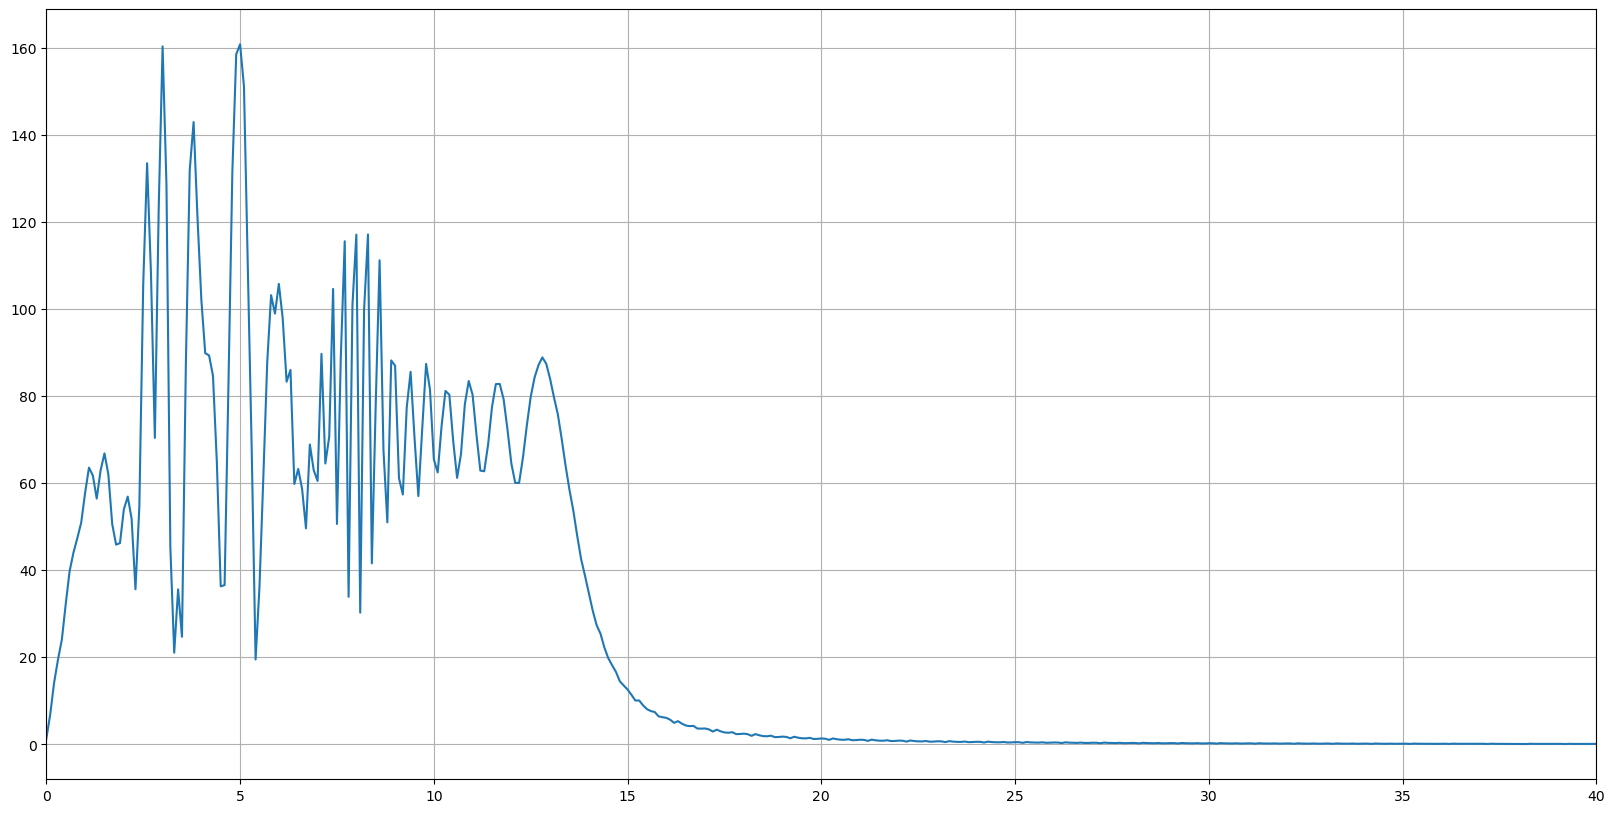

In [9]:
plt.figure(figsize=[20,10])
plt.plot(frequencies, np.abs(spectrum))
# plt.xlabel("MHz")
plt.xlim(0,40)
plt.grid()
plt.show()